# Cycling Data explorer

This notebook outlines some of the routines available in `data_analysis.py`.

We investigate two bike rides - one a 100km outdoor ride in the Surrey Hills, the other an indoor ride on a Wattbike. We demonstrate some feature extraction methods and data visualization, and use a model relating Wattbike power to measured speed to estimate power output on the longer outdoor ride (for which power data was not available).

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
from bs4 import BeautifulSoup
from itertools import starmap
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from data_analysis import *

pd.plotting.register_matplotlib_converters()

In [3]:
FULL_RUN = True

File loading is easy:

In [23]:
%time df_gpx = load_file('Lucozade_sport_is_the_best_drink_of_all_time.gpx')
%time df_tcx = load_file('5G0G6PsD9V_jOo5zdK0S4.tcx')
df_gpx.head(3)

CPU times: user 7.8 s, sys: 201 ms, total: 8 s
Wall time: 8.4 s
CPU times: user 1.18 s, sys: 31.7 ms, total: 1.21 s
Wall time: 1.24 s


,Latitude,Longitude,Elevation,HeartRateBpm,Cadence,Temperature
Time,,,,,,
2019-06-01 09:31:56,51.112387,-0.186590,83.8,91.0,62.0,NaN
2019-06-01 09:31:57,51.112385,-0.186592,83.8,91.0,62.0,NaN
2019-06-01 09:31:58,51.112383,-0.186594,83.8,91.0,62.0,NaN


And grab an image cutout of the bike ride:

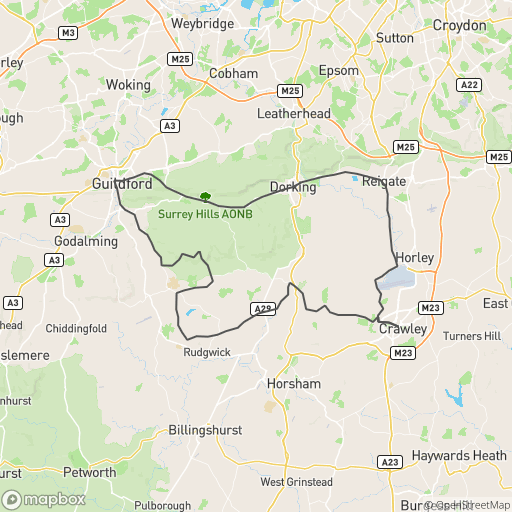

In [5]:
MAPBOX_TOKEN = 'pk.eyJ1IjoidGtsaW5nYXJkIiwiYSI6ImNqdzdwam1kYjE1eHg0OG1zMXdqM3h0eTcifQ.8PYzaDbDDlbS_zh7aC3MFQ'

N = 300
overlay = encode_geojson(df_gpx, n=N)
while len(overlay) > 2084:
  N -= 10
  overlay = encode_geojson(df_gpx, n=N)
im = get_mapbox_image(token=MAPBOX_TOKEN, overlay=overlay)
im

We ought to augment this data with calculated values (feature extraction); our gpx file doesn't have a record of distance travelled, gradient or speed. We calculate distance using the haversine formula and the recorded latitude and longitude:

In [6]:
df_gpx['DistanceMeters'] = get_distance(df_gpx)
df_gpx['Distance'] = df_gpx['DistanceMeters'] / 1000  # distance in km, useful for plotting

We can then caulcate speed from $\frac{\mathrm{d}x}{\mathrm{d}t}$

In [7]:
df_gpx['Speed'] = get_speed(df_gpx)

And use Elevation and Distance to calculate gradient:

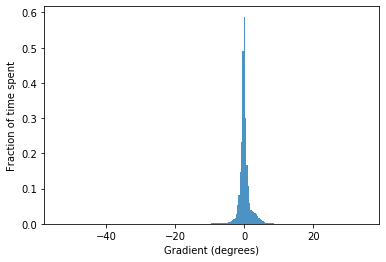

In [8]:
df_gpx['Gradient'] = get_gradient(df_gpx)
plt.hist(df_gpx['Gradient'].dropna(), density=True, alpha=0.8, bins='scott')
plt.xlabel('Gradient (degrees)')
plt.ylabel('Fraction of time spent');

Now we can make those lovely plots you see on Strava (and other pain-monitoring sites)

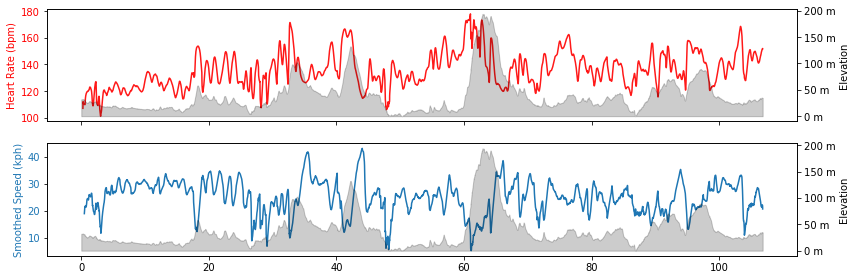

In [9]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=2, sharex=True)
plt.sca(ax[0])
# plot heart rate
plt.plot(df_gpx['Distance'], df_gpx['HeartRateBpm'].rolling(50).mean(), color='r', alpha=0.9)
plt.gca().tick_params(axis='y', labelcolor='r')
plt.ylabel('Heart Rate (bpm)', color='r')
# plot elevation
plt.sca(plt.gca().twinx())
plt.fill_between(
    df_gpx['Distance'],
    np.zeros_like(df_gpx['Elevation']),
    df_gpx['Elevation'] - df_gpx['Elevation'].min(),
    color='k',
    alpha=0.2,
)
plt.ylabel('Elevation')
new_ticks = np.arange(0, plt.ylim()[1]+1, 50).astype(int)
plt.yticks(
    new_ticks,
    ['{} m'.format(i) for i in new_ticks]
)
# second panel
plt.sca(ax[1])
# plot speed
plt.plot(df_gpx['Distance'], df_gpx['Speed'].rolling(90).mean(), color='C0', alpha=1)
plt.gca().tick_params(axis='y', labelcolor='C0')
plt.ylabel('Smoothed Speed (kph)', color='C0')
# plot elevation again
plt.sca(plt.gca().twinx())
plt.fill_between(
    df_gpx['Distance'],
    np.zeros_like(df_gpx['Elevation']),
    df_gpx['Elevation'] - df_gpx['Elevation'].min(),
    color='k',
    alpha=0.2,
)
plt.xlabel('Distance travelled (km)')
plt.ylabel('Elevation')
new_ticks = np.arange(0, plt.ylim()[1]+1, 50).astype(int)
plt.yticks(
    new_ticks,
    ['{} m'.format(i) for i in new_ticks]
)
plt.tight_layout();

We can also spatially plot things like elevation, speed and heart rate, though not easily on a map (curse you mapbox for not allowing bounding box queries easily)

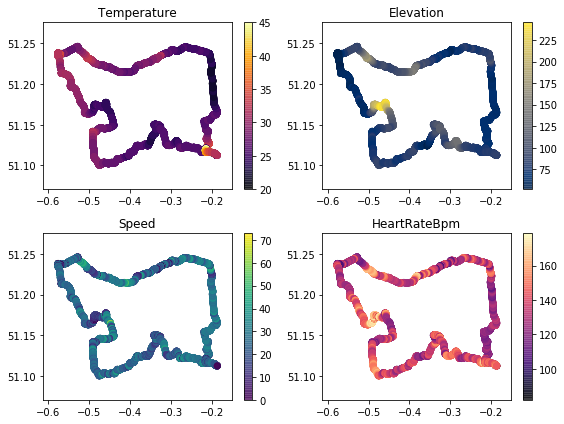

In [10]:
f, axs = plt.subplots(ncols=2, nrows=2, squeeze=True, figsize=(8, 6))
axs = [j for i in axs for j in i]
plot_labels = ('Temperature', 'Elevation', 'Speed', 'HeartRateBpm')
plot_cmaps = ('inferno', 'cividis', 'viridis', 'magma')
for ax, label, cmap in zip(axs, plot_labels, plot_cmaps):
    plt.sca(ax)
    plt.scatter(
        df_gpx['Longitude'], df_gpx['Latitude'],
        c=df_gpx[label], cmap=cmap, alpha=0.5
    )
    plt.title(label)
    plt.colorbar(ax=ax)
plt.tight_layout();

Let's see where in the ride I needed a break (or was stuck at lights or in traffic...):

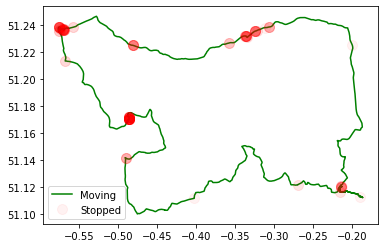

In [11]:
mask = df_gpx['Distance'].diff() != 0
plt.plot(
    df_gpx['Longitude'][mask], df_gpx['Latitude'][mask],
    'g', markersize=1, label='Moving',
)
plt.plot(
    df_gpx['Longitude'][~mask], df_gpx['Latitude'][~mask],
    'or', alpha=1/20, markersize=10, label='Stopped',
)
plt.legend();

## Power data

Okay, we've shown it's pretty easy to interact with gpx data (location, elevation & extensions), but the big bit of data missing here is **Power!**

We'll load a file from an interval session on a Wattbike, and see what we can learn from it!

<img src="https://i.ytimg.com/vi/WeRo6VYqMPw/hqdefault.jpg" style="width:200px;margin:auto"/>

In [12]:
df_tcx['Distance'] = get_distance(df_tcx, from_speed=True)
df_tcx['DistanceMeters'] = df_tcx['Distance'] * 1000
df_tcx.head(4)

,DistanceMeters,Cadence,Speed,Watts,HeartRateBpm,Distance
Time,,,,,,
2019-01-11 17:22:28,0.00,86.0,7.96,100.0,100.0,0.00000
2019-01-11 17:22:29,7.88,86.0,7.88,97.0,100.0,0.00788
2019-01-11 17:22:30,15.74,85.0,7.86,97.0,100.0,0.01574
2019-01-11 17:22:32,21.48,33.0,2.87,6.0,102.0,0.02148


Let's have a look at these intervals:

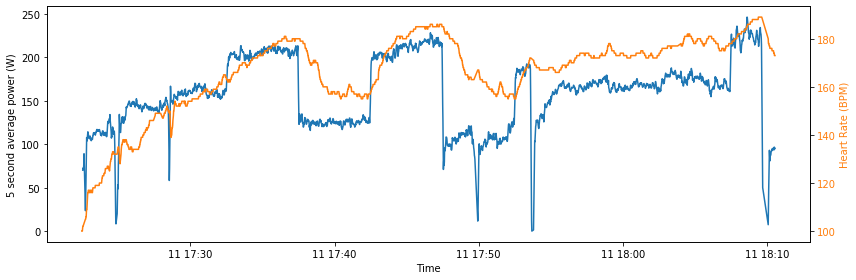

In [13]:
df_interpolated = interpolate_to_second(df_tcx[['Watts', 'HeartRateBpm']])
dt = pd.to_timedelta(df_interpolated.index - df_interpolated.index[0]).values
plt.figure(figsize=(12, 4))
plt.plot(df_interpolated['Watts'].rolling(5).mean())
plt.ylabel('5 second average power (W)')
plt.xlabel('Time');
plt.sca(plt.gca().twinx())
plt.plot(df_interpolated['HeartRateBpm'], c='C1')
plt.ylabel('Heart Rate (BPM)', color='C1')
plt.gca().tick_params(axis='y', labelcolor='C1')
plt.xlabel('Time')
plt.tight_layout();

### Calculating a Power curve

We can make use of boxcar smoothing to easily calculate the maximum N-Second power held during the workout:

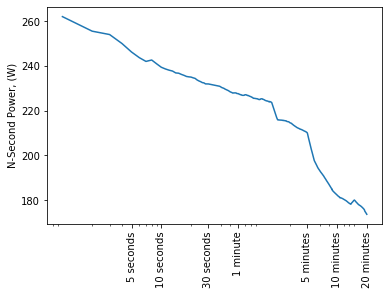

In [14]:
power_curve = pd.Series({i: get_ns_power(df_interpolated, i).max() for i in range(1, 60*20)})
plt.plot(power_curve)
plt.xscale('log')
plt.ylabel('N-Second Power, (W)')
plt.xticks(
    [5, 10, 30, 60, 5*60, 10*60, 20*60],
    ['5 seconds', '10 seconds', '30 seconds', '1 minute', '5 minutes', '10 minutes', '20 minutes'],
    rotation=90
);

### Recovering Wattbike's relationship between Power and Speed

For a cyclist of weight $W$ going up a gradient $\theta$, with air density $\rho$, a coefficient of rolling resistance $C_{rr}$, drivetrain efficiency $E_\text{dt}$, cross-sectional area $A$ and drag coefficient $C_d$,
$$P = P_\text{legs}E_\text{dt} = mgv(\sin\theta + C_{rr}\cos\theta) + \frac{1}{2}C_dA\rho v^3.$$

i.e. 
$$P_\text{legs} = C_0v + C_1v^3.$$

[Source](https://www.gribble.org/cycling/power_v_speed.html).

Note that this equation assumes $\frac{\mathrm{d}v}{\mathrm{d}t} \simeq 0$ otherwise we ought to incorporate the change in kinetic energy into the equation as well.

We use `scikit-learn` to throw together a quick model which fits for power given speed, and fit for what wattbike uses as these coefficients:

We'll fit both the $P = C_0v + C_1v^3$ model above, and a general higher-order polynomial $P = \sum_{{i=1}}^5C_iv^i$ to see if there are some other terms Wattbike is using that isn't in the formula above. We fix $P_\text{legs}(v=0) = 0$ as a boundary (i.e. don't fit an intercept).

We'll calculate a cross-validated score for each model and simply take the mean value as that model's score. We'll use negative median absolute error as a metric as it is more resilient to outliers (a higher score is better). 

In [15]:
X = np.expand_dims(df_tcx['Speed'], 1)
X_simple = np.concatenate((X, X**3), axis=1)
X_predict = np.expand_dims(
    np.linspace(
        df_tcx['Speed'].min(),
        df_tcx['Speed'].max(),
        100
    ), 1
)
X_simple_predict = np.concatenate((X_predict, X_predict**3), axis=1)

y = df_tcx['Watts']

In [16]:
r_simple = LinearRegression(fit_intercept=False)
r_simple.fit(X_simple, y)
Y_simple = r_simple.predict(X_simple_predict)
score_simple = cross_val_score(r_simple, X_simple, y, cv=5, scoring='neg_median_absolute_error').mean()

Ideally we would perform the complex fit using Bayesian Automatic Relevance Determination, which is better than simple OLS as it stabilises feature weights due to a sparsity-inducing prior (i.e. it likes to leave coefficients at zero), which is ideal for the question we are asking: whether certain coefficients should be zero.

However, `ARDRegression` takes a significantly longer time than OLS (and can cause memory problems), so I'm only mentioning it as an aside.

In [17]:
r_complex = Pipeline(steps=(
  ('features', PolynomialFeatures(degree=5, include_bias=False)),
  ('regressor', LinearRegression(fit_intercept=False)),
))
r_complex.fit(X, y)
Y_complex = r_complex.predict(X_predict)
score_complex = cross_val_score(
    r_complex, X, y,
    cv=5, scoring='neg_mean_squared_error'
).mean()

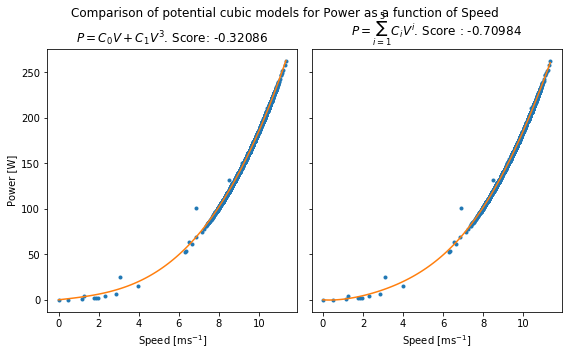

In [18]:
fig, ax = plt.subplots(ncols=2, sharey=True, figsize=(8, 5))
plt.sca(ax[0])
plt.plot(df_tcx['Speed'], df_tcx['Watts'], '.')
plt.plot(X_predict[:, 0], Y_simple)
plt.title('$P = C_0V + C_1V^3$. Score: {:.5f}'.format(score_simple))
plt.xlabel(r'Speed [$\mathrm{ms}^{-1}$]')
plt.ylabel('Power [W]')
plt.sca(ax[1])
plt.plot(df_tcx['Speed'], df_tcx['Watts'], '.')
plt.plot(X_predict[:, 0], Y_complex)
plt.title(r'$P = \sum_{{i=1}}^5C_iV^i$. Score : {:.5f}'.format(score_complex))
plt.xlabel(r'Speed [$\mathrm{ms}^{-1}$]')
plt.suptitle('Comparison of potential cubic models for Power as a function of Speed')
plt.tight_layout();

The scores are almost identical between models, suggesting that our above model ($P_\text{legs}$) is a good match (the more complex model actually appears to over-fit). This is despite the parameters of the models being very different.

In [19]:
print('Coefficient of P_legs model:\n\tP = {:.3f} v^3 + {:.3f} V'.format(*r_simple.coef_[::-1]))

print('Coefficients of higher-order polynomial:\n\tP = '+' '.join(starmap(
    lambda i, s: f'{s:+.3f} v^{i + 1}',
    list(enumerate(r_complex.named_steps['regressor'].coef_))[::-1]
)))

Coefficient of P_legs model:
	P = 0.161 v^3 + 2.469 V
Coefficients of higher-order polynomial:
	P = -0.002 v^5 +0.056 v^4 -0.418 v^3 +2.541 v^2 -1.545 v^1


## Why is this useful?

We now have a model for power as a function of speed that we can apply to our GPX data above (which doesn't contain power data). Looking at the equation above for $P_\text{legs}$ we see that we need to take into account the road gradient in the $v$ coefficient. As the wattbike data above was recorded for $\theta = 0$, we have that $C_0 = mgC_{rr}$, so our function will become

$$P_\text{legs} = \left(\frac{C_0}{C_{rr}}\sin\theta + C_0\cos\theta\right)v + C_1v^3,$$

Where $C_0$ and $C_1$ were fitted above.

There would be some significant changes to other parameters detailed above as well, but as we have no means of measuring them we'll have to assume they don't vary.

We will assume a value of $C_{rr} = 0.003$, which is consistent with those recorded [here](http://biketechreview.com/tires/rolling-resistance/475-roller-data).

In [20]:
CRR = 0.003
C_0, C_1 = r_simple.coef_
theta = np.deg2rad(get_gradient(df_gpx))
V = df_gpx['Speed'] * 10 / 36  # convert to metres per second (from kph)

def P_est(theta, V):
    return (
        (C_0 / CRR * np.sin(theta) + C_0 * np.cos(theta)) * V
        + C_1 * V**3
    )

Now let's finish those charts from earlier!

Power estimate:
mean    1.086175e+02
std     6.545173e+01
min     2.774191e-13
max     8.202797e+02
dtype: float64


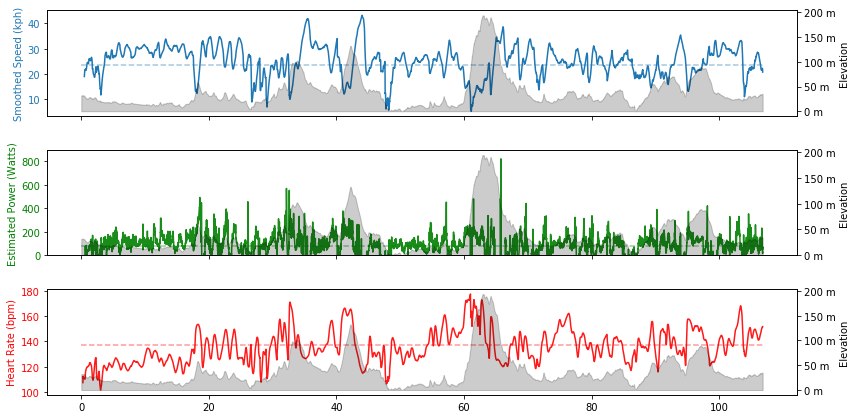

In [21]:
estimated_power = P_est(theta, V)
print('Power estimate:')
print(estimated_power[estimated_power > 0].describe()[['mean', 'std', 'min', 'max']])

fig, ax = plt.subplots(figsize=(12, 6), nrows=3, sharex=True)
plt.sca(ax[0])
# plot speed
plt.plot(df_gpx['Distance'], df_gpx['Speed'].rolling(90).mean(), color='C0', alpha=1)
plt.hlines(
  df_gpx['Speed'].mean(),
  df_gpx['Distance'].min(),
  df_gpx['Distance'].max(),
  color='C0', linestyles='dashed', alpha=0.4
)
plt.gca().tick_params(axis='y', labelcolor='C0')
plt.ylabel('Smoothed Speed (kph)', color='C0')
# plot elevation
plt.sca(plt.gca().twinx())
plt.fill_between(
    df_gpx['Distance'],
    np.zeros_like(df_gpx['Elevation']),
    df_gpx['Elevation'] - df_gpx['Elevation'].min(),
    color='k',
    alpha=0.2,
)
plt.xlabel('Distance travelled (km)')
plt.ylabel('Elevation')
new_ticks = np.arange(0, plt.ylim()[1]+1, 50).astype(int)
plt.yticks(
    new_ticks,
    ['{} m'.format(i) for i in new_ticks]
)
# second panel
plt.sca(ax[1])
# plot power
plt.plot(df_gpx['Distance'], estimated_power, color='g', alpha=0.9)
plt.hlines(
  estimated_power.mean(),
  df_gpx['Distance'].min(),
  df_gpx['Distance'].max(),
  color='g', linestyles='dashed', alpha=0.4
)
plt.gca().tick_params(axis='y', labelcolor='g')
plt.ylabel('Estimated Power (Watts)', color='g')
plt.ylim(0);  # negative power = braking!
# plot elevation
plt.sca(plt.gca().twinx())
plt.fill_between(
    df_gpx['Distance'],
    np.zeros_like(df_gpx['Elevation']),
    df_gpx['Elevation'] - df_gpx['Elevation'].min(),
    color='k',
    alpha=0.2,
)
plt.ylabel('Elevation')
new_ticks = np.arange(0, plt.ylim()[1]+1, 50).astype(int)
plt.yticks(
    new_ticks,
    ['{} m'.format(i) for i in new_ticks]
)
plt.ylim(0);  # negative power = braking!
# third panel
plt.sca(ax[2])
# plot heart rate
plt.plot(df_gpx['Distance'], df_gpx['HeartRateBpm'].rolling(50).mean(), color='r', alpha=0.9)
plt.hlines(
  df_gpx['HeartRateBpm'].mean(),
  df_gpx['Distance'].min(),
  df_gpx['Distance'].max(),
  color='r', linestyles='dashed', alpha=0.4
)
plt.gca().tick_params(axis='y', labelcolor='r')
plt.ylabel('Heart Rate (bpm)', color='r')
# plot elevation
plt.sca(plt.gca().twinx())
plt.fill_between(
    df_gpx['Distance'],
    np.zeros_like(df_gpx['Elevation']),
    df_gpx['Elevation'] - df_gpx['Elevation'].min(),
    color='k',
    alpha=0.2,
)
plt.ylabel('Elevation')
new_ticks = np.arange(0, plt.ylim()[1]+1, 50).astype(int)
plt.yticks(
    new_ticks,
    ['{} m'.format(i) for i in new_ticks]
)
plt.tight_layout();

For comparison, here's Strava's estimate:

![Series of plots containing Speed, estimated power and heart rate from strava.com](strava_analysis.png)

It appears that this analysis has smoothed the data significantly more than they have, but the comparative values are still sensible!

It is very likely that Strava's model is more comprehensive than the one presented here, given the volume of training data and number of analysists they have at their disposal, but the work here is a good first start!

## Consistency checking

Observing the Power vs Elevation plot, we also see that on steep downhills the model is predicting a positive power output (i.e. it's assuming I'm having to push to get up to that speed despite the gradient, whereas I'm actually probably coasting). This might be a result of the boxcar smoothing used, or variations in the parameters of the $P_\text{legs}$ model between the indoor and outdoor rides.

To investigate this, let's see what gradient I'd need to theoretically hold 40kph on a downhill without pedalling (something like 5% from experience)

      converged: True
           flag: 'converged'
 function_calls: 6
     iterations: 5
           root: -1.5534991345035107


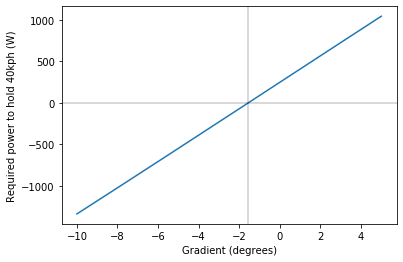

In [26]:
V = 40 / 3.6
theta_est = np.deg2rad(np.linspace(-10, 5, 100))
plt.plot(
    np.rad2deg(theta_est),
    P_est(theta_est, V)
)
plt.xlabel('Gradient (degrees)')
plt.ylabel('Required power to hold 40kph (W)')
plt.axhline(0, color='k', alpha=0.2)
root = root_scalar(lambda t: P_est(np.deg2rad(t), 40 / 3.6), bracket=(-10, 0))
plt.axvline(root.root, color='k', alpha=0.2)
print(root)

The model predicts that I'd need a downholl gradient of 1.55˚ to hold a speed of 40kph without pedalling. This feels optimistic, suggesting that (as theorized above) simply using the wattbike model is an overly simplistic approach.

## A more complicated model

The assumption of the above model is that acceleration is always zero, which is unphysical! Instead, We can add a term which incorporates the power needed to increase the kinetic energy of the cyclist and bike, and to increase the angular kinetic energy of the wheels (which we approximate as toruses of zero thickness):

$$P_\text{legs}E_\text{dt} = (m + m_w)v\frac{\mathrm{d}v}{\mathrm{d}t} + mgv\left(\sin\theta + C_{rr}\cos\theta\right) + \frac{1}{2}C_dA\rho v^3,$$

or

$$P_\text{legs} = C_0v\frac{\mathrm{d}v}{\mathrm{d}t} + C_1v\left(\sin\theta + C_{rr}\cos\theta\right) + C_2 v^3,$$

Where $\frac{\mathrm{d}v}{\mathrm{d}t}$ is the acceleration and $m_w$ is the combined wheel mass.

In order to compute this new equation, we would need to re-fit from the wattbike data, incorporating assumptions about degenerate parameters, which is a notebook for another time!